# Upper level tests
## Conjugate gradient

In [1]:
from algo.pdhg import pdhg

In [2]:
import numpy as np
import scipy.sparse.linalg
import scipy.optimize
import time

In [3]:
A = np.random.rand(512,512)
B = np.dot(A,A.transpose())
b = np.random.rand(512,)

t1=time.time()
x,convergence = scipy.sparse.linalg.cg(B,b,tol=1e-7)
print(time.time()-t1)

0.06992411613464355


In [4]:
print(np.linalg.norm(B.dot(x)-b)/np.linalg.norm(b))

3.9251999967045865e-08


## LBFGS-B
First example: we find the subsampling operator $\mathcal{S}$ minimizing $||\mathcal{S}\mathcal{F}u_0-y||^2$ with y the full noised measurements.

In [90]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt

In [6]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0.data))+1e-6*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [39]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

In [87]:
# f=lambda x:np.linalg.norm(x)**2
# grad_f=lambda x:2*x
Fu = np.real(fourier_op.op(u0_mat))
y = np.real(y)
c = 1e7

f = lambda x:c*np.linalg.norm(x*y-Fu)**2
grad_f = lambda x:2*c*(x*y-Fu)*y
def pf(x):
    global l,f
    fx=f(x)
    l.append(fx)
    print(fx)

In [13]:
f(np.ones(512*512))

0.052605487891815336

In [96]:
t1=time.time()
l=[]
res = scipy.optimize.minimize(f,np.zeros((512,512)),method='L-BFGS-B',jac=grad_f,bounds=[(0,1)]*512*512,callback=pf,
                             options={'ftol':1e-5})
pf(res.x)
print(f"Time: {time.time()-t1}s")

5.275095583226344
5.015885943679776
3.3616185642168075
2.7008139424951048
2.308712683964563
1.976768875773779
1.892677227158947
1.6483663457630418
1.2552521802398124
1.1816089565922887
1.1582434880105597
1.083998041678468
0.972342848839779
0.8363939966389364
0.7373204950620852
0.7161559090375229
0.7026663574496941
0.6364526380276107
0.6220966077108794
0.5831288138592278
0.5708806924139547
0.5582776540410854
0.5379583947213836
0.5119978875322525
0.4951465505505691
0.4905812119748609
0.489534730397691
0.48101272400697265
0.4502948781605868
0.44572393601069565
0.4417429110277678
0.4265150723580491
0.4196751667248041
0.4096412761563639
0.401608561290835
0.39757138093126776
0.39421096701824837
0.39157738623419336
0.37337307427667127
0.3659924926173603
0.3621402482667991
0.3563447518486437
0.35450888267703456
0.35325010368601784
0.3464377593433902
0.33771790608903485
0.33395183222217767
0.3294396615196851
0.32548953353603355
0.32425420445512226
0.32209318740360626
0.31859513194037054
0.31551

0.15574177193437239
0.15566261924573466
0.15556559324706457
0.15546507691360562
0.15539479318931818
0.1552870774365785
0.1552226096256351
0.15519169024966226
0.15513195376288763
0.15510549514300886
0.15505595680016818
0.15498370739377193
0.1549601417988348
0.15489769834488265
0.15486185791899612
0.15481424328601348
0.15477486926471176
0.1547053521168631
0.15466873423783747
0.15461017350433287
0.1545792598798899
0.15455544211214245
0.15452197536807963
0.15449792010493163
0.15446438505710128
0.1543998843752224
0.15431211671793318
0.15425588720210834
0.154239243244389
0.15416606859855903
0.15412064637072345
0.1540931294489364
0.15405563684869097
0.15403468872569392
0.15398062229561182
0.15393563212203684
0.1539163350260412
0.15389161744012061
0.15385046029783384
0.1537832819038999
0.1537130660178115
0.15366218331857678
0.15364032164970004
0.1535897805287368
0.153549843746709
0.15346810607046885
0.15343059672145254
0.1534124252694748
0.15336157015338597
0.15332229190106217
0.15326415364329

597


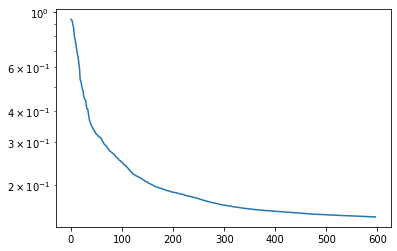

In [95]:
print(len(l))
plt.plot(l)
plt.yscale("log")

In [94]:
pysap.Image(data=np.reshape(res.x,u0.shape)).show()

In [93]:
print(ssim(fourier_op.adj_op(res.x*y),u0_mat))
pysap.Image(data=fourier_op.adj_op(res.x*y)).show()

0.772622177299408


'jac' parameter (i.e. gradient) needed, otherwise bad results and very slow.\
Results for ftol=1e-12 for different initialisations:
* radial mask: $f_{final}$=0.001653, ssim=0.76756
* empty mask: $f_{final}$=0.001578, ssim=0.76785
* full mask: $f_{final}$=0.001628, ssim=0.76928